<a href="https://colab.research.google.com/github/jaegon-kim/python_study/blob/main/src/ai_essential_250317/house_price_prediction/prediction_dropout_batch_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Price Prediction
- **목표**
  - 이 워크샵은 주어진 데이터셋을 이용해 심층신경망 모델을 학습시켜 주택의 최종 판매 가격(SalePrice)을 예측하는 것이 최종 목표입니다.

- **데이터셋 정보**
  - 데이터셋은 총 79개의 설명 변수와 타겟 변수인 주택 가격(SalePrice)로 구성됩니다.
  - 설명 변수는 주택의 다양한 특성(예: 건축 연도, 면적, 위치, 방 개수 등)을 포함합니다.
  - 데이터는 판매 가격이 포함된 학습용 데이터인 `X`, `y` 와 판매 가격이 포함되지 않은 평가용 데이터인 `TEST`파일로 나뉘며, 각각 모델 학습 및 평가에 사용됩니다.
    - 평가용 데이터 `TEST`의 판매 가격(SalePrice)를 예측 후 리더보드로 제출하여 평가합니다.

- **문제 유형**
  - 이 워크샵은 회귀 문제로 연속형 변수를 예측하는 것이 목표입니다. 모델의 성능은 `Mean Absolute Error`로 측정됩니다.

## 1. 환경 설정

In [1]:
%%capture
!pip install JAEN -U

In [2]:
# 그대로 실행하세요.
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from JAEN.utils import plot_training_results


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 2. 데이터 로드

In [3]:
from JAEN.datasets import load_house_price
X, y, TEST = load_house_price()
X.shape, y.shape, TEST.shape

(torch.Size([1460, 79]), torch.Size([1460, 1]), torch.Size([1459, 79]))

In [4]:
train_X, train_y = X[:1400, :], y[:1400, :]
test_X, test_y = X[1400:, :], y[1400:, :]

train_X.shape, train_y.shape, test_X.shape, test_y.shape

(torch.Size([1400, 79]),
 torch.Size([1400, 1]),
 torch.Size([60, 79]),
 torch.Size([60, 1]))

## 3. 제출 예시 코드

## 4. 심층신경망 모델을 구성하고 학습하여 TEST를 예측해보세요.
- TEST의 예측 결과는 `comp.prediction`에 대입해주세요. **torch.tensor** 형태여야합니다.

In [5]:
# DataLoader 생성
from torch.utils.data import DataLoader, TensorDataset
train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(test_X, test_y), batch_size=32, shuffle=True)


In [6]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # 모델을 학습 모드로 설정

    running_loss = 0.0 # 미니 배치별 loss값을 누적할 변수

    for data, labels in train_loader: # 미니 배치 별 파라미터 업데이트 수행
        data, labels = data.to(device), labels.to(device) # 미니 배치별 데이터와 레이블 장치 할당

        # 순전파
        outputs = model(data)

        # 손실 계산
        loss = criterion(outputs, labels)

        # 기울기 초기화
        optimizer.zero_grad()

        # 역전파
        loss.backward()

        # 파라미터 업데이트
        optimizer.step()

        # 손실 누적
        running_loss += loss.item()

    # 현재 Epoch의 평균 손실 값 계산 및 반환
    # - len(train_loader): 평균 Loss
    return running_loss / len(train_loader)

In [7]:
# 평가 함수 정의
def evaluate(model, test_loader, criterion, device):
    model.eval()  # 모델을 평가 모드로 설정

    running_loss = 0.0 # 미니 배치별 loss값을 누적할 변수

    with torch.no_grad():  # 평가 중에는 기울기 계산을 하지 않음
        for data, labels in test_loader: # 미니 배치 별 손실 계산
            data, labels = data.to(device), labels.to(device) # 미니 배치별 데이터와 레이블 장치 할당

            # 순전파
            outputs = model(data)

            # 손실 계산
            loss = criterion(outputs, labels)

            # 손실 누적
            running_loss += loss.item()


    # 현재 Epoch의 평균 손실 값 계산 및 반환
    return running_loss / len(test_loader)

In [8]:
# DNN 모델 구성
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(79, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # 10%의 드롭아웃 적용

    def forward(self, x):
        #x = self.relu(self.fc1(x))
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = DNN().to(device)
#summary(model)


In [9]:
# 손실함수 및 옵티마이저 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [10]:
train_losses = []
test_losses = []

# Early Stopping을 위한 변수 설정
best_loss = float('inf')
patience = 300
counter = 0

# 학습 횟수 만큼 반복
for epoch in range(1000):

    # 모델 학습(학습데이터)
    train_loss = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # 모델 평가 (평가데이터)
    test_loss = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)

    #print(f'Epoch {epoch+1} Train Loss : {train_loss} Test Loss : {test_loss}')

    # Early Stopping 조건 체크
    #if test_loss < best_loss:
    #    best_loss = test_loss
    if train_loss < best_loss:
        best_loss = train_loss
        counter = 0
        print(f'Save model Epoch {epoch+1} Train Loss : {train_loss} Test Loss : {test_loss}')
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        counter += 1

    if counter >= patience:
        print(f'Early stopping trigerred at epoch {epoch+1}')
        break

model.load_state_dict(torch.load('best_model.pt'))

Save model Epoch 1 Train Loss : 39148547165.09091 Test Loss : 35437086720.0
Save model Epoch 2 Train Loss : 39105170664.72727 Test Loss : 35427748864.0
Save model Epoch 3 Train Loss : 39054973440.0 Test Loss : 35355309056.0
Save model Epoch 5 Train Loss : 38999567639.27273 Test Loss : 35465945088.0
Save model Epoch 6 Train Loss : 38820806330.181816 Test Loss : 35372455936.0
Save model Epoch 7 Train Loss : 38609370158.545456 Test Loss : 34987127808.0
Save model Epoch 8 Train Loss : 38387803927.27273 Test Loss : 34873369600.0
Save model Epoch 9 Train Loss : 38026170880.0 Test Loss : 35112162304.0
Save model Epoch 10 Train Loss : 37702724328.72727 Test Loss : 34634039296.0
Save model Epoch 11 Train Loss : 37227319389.09091 Test Loss : 33613310976.0
Save model Epoch 12 Train Loss : 36602668544.0 Test Loss : 33491279872.0
Save model Epoch 13 Train Loss : 35912505250.90909 Test Loss : 32647052288.0
Save model Epoch 14 Train Loss : 35232307898.181816 Test Loss : 31779171328.0
Save model Epoch

<All keys matched successfully>

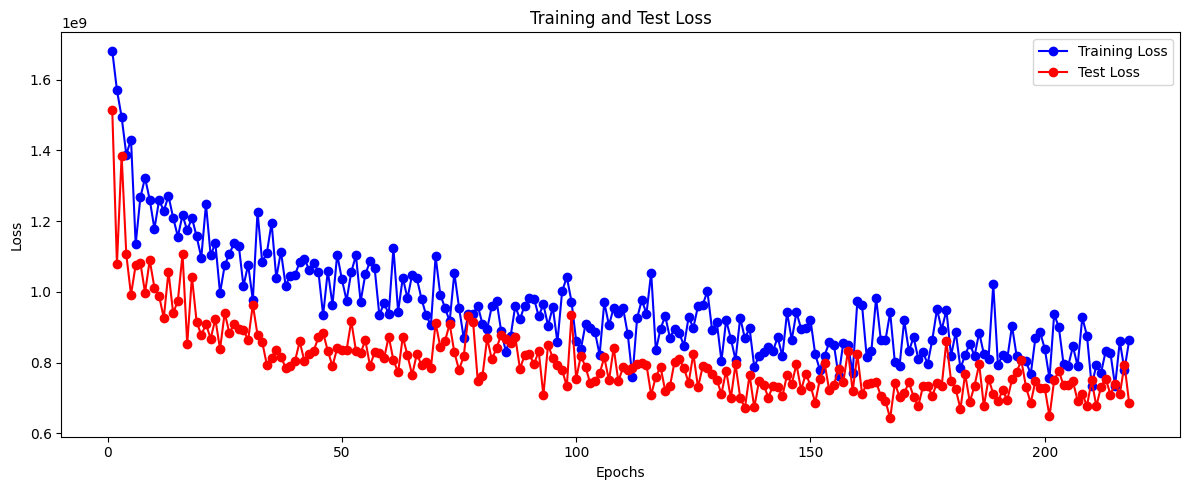

In [11]:
plot_training_results(train_losses[50:268], test_losses[50:268])

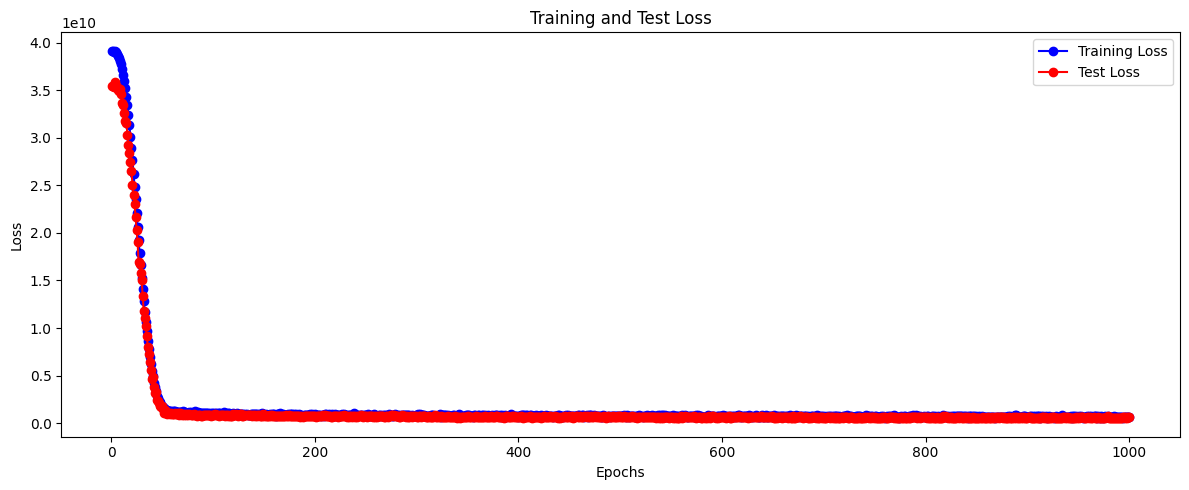

In [12]:
plot_training_results(train_losses, test_losses)

In [ ]:
# 사용자명을 입력하세요. (이름이 아니여도 괜찮습니다.)
username = "김재곤"
assert username, "username 변수에 값이 설정되지 않았습니다."

# 그대로 실행하세요.
from JAEN.competition import Competition
comp = Competition(
    username=username,
    course_name='AI Essential',
    course_round='0317(1)',
    competition_name='House Price Prediction'
)

# 학습된 모델의 TEST 예측
model.eval()
TEST2 = TEST.to(device)
with torch.no_grad():
    outputs = model(TEST2)
outputs

# comp.prediction에 TEST 예측 결과 대입
comp.prediction = outputs
comp.prediction

# 제출
#comp.submit()

tensor([[121247.6875],
        [202987.8750],
        [182309.3125],
        ...,
        [170851.1562],
        [130731.7500],
        [240880.2344]], device='cuda:0')